# Signal per DOM

Load a simulation and plot the signal per DOM.

In [1]:
from asteria import config, source, IO
from asteria.interactions import Interactions
from asteria.neutrino import Flavor
from asteria.config import parse_quantity
import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Set up styles for plotting

In [2]:
axes_style =   {            'grid' : 'True',
                       'labelsize' : '24',
                        'labelpad' : '8.0' }

xtick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5.',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

ytick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

grid_style =   {           'alpha' : '0.75' }
legend_style = {        'fontsize' : '18' }
font_syle =    {            'size' : '20'}
text_style =   {          'usetex' : 'True' }
figure_style = {  'subplot.hspace' : '0.05' }

mpl.rc(    'font', **font_syle )
mpl.rc(    'text', **text_style )
mpl.rc(    'axes', **axes_style )
mpl.rc(   'xtick', **xtick_style )
mpl.rc(   'ytick', **ytick_style )
mpl.rc(    'grid', **grid_style )
mpl.rc(  'legend', **legend_style )
mpl.rc(  'figure', **figure_style )

mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/default.yaml')
ccsn = source.initialize(conf)

## Prepare Iterables

Read from the configuration, the range of neutrino energies (`Enu`) to simulate and the times (`time`) at which to perform the simulation. Defining the time and energy arrays in this manner (end-point inclusive) aligns with the definition in `asteria.simulationHandler`.

In [4]:
# Define neutrino energy spectrum
E_min = parse_quantity(conf.simulation.energy.min).to(u.MeV).value
E_max = parse_quantity(conf.simulation.energy.max).to(u.MeV).value 
dE = parse_quantity(conf.simulation.energy.step).to(u.MeV).value
Enu = np.arange(E_min, E_max+dE, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = parse_quantity(conf.simulation.time.min).to(u.s).value
t_max = parse_quantity(conf.simulation.time.max).to(u.s).value 
dt = parse_quantity(conf.simulation.time.step).to(u.s).value
time = np.arange(t_min, t_max+dt, dt) * u.s

## Load Simulation and Compute Signal per DOM

Import a simulation from the file `\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5` using `IO.load()`. It is assumed that this file has already been generated$^*$. This file is specific to the model and its path is stored in the `conf` object. The configuration parameters describing the simulation are contained within the `config.simulation` node as follows...

- `interactions` The neutrino interactions used to perform the simulation
- `flavors` The neutrino flavors used to perform the simulation
- `hierarchy` The neutrino mass hierarchy used to perform neutrino oscillations.
- `energy` The Energy resolution at which cross sections, lepton mean energy, and the source PDFs were binned.
  - Contains 4 nodes `min`, `max`, `step`, and `size`
- `time` The Time resolution at which the simulation profile is binned.
  - Contains 4 nodes `min`, `max`, `step`, and `size`

If no object is found, `None` will be returned.

The code to save a simulation to file is ...

```IO.save(conf, result)```

Where `result` is the photonic energy deposition in 1 m$^3$ of ice scaled to a progenitor that is 1 kpc away. This is scaled to progenitor distance of the source and the effective volume of a DOM to find the expected signal increase for a single DOM.


$^*$__NOTE__: This notebook assumes that the simulation described in `\data\config\default.yaml` has already been performed and saved. It will be written to the file `\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5`. To generate this file, run the notebook `\docs\nb\detector_response.ipynb`.

In [5]:
effvol = 0.1654 * u.m**3 / u.MeV

E_per_V = IO.load(conf) * u.MeV / u.m**3
E_per_V /= ccsn.progenitor_distance.to(u.kpc).value**2
signal_per_DOM = effvol * E_per_V 

## Plot Signal Increase Per DOM
This will plot the signal increase in a single DOM caused by each flavor. The curve shows the DOM response from 0.05 seconds before the core bounce to 0.65 seconds after the core bounce. Note that this is computed with the assumption that the effective volume of the DOM is 0.1654 m$^3$ MeV$^{-1}$

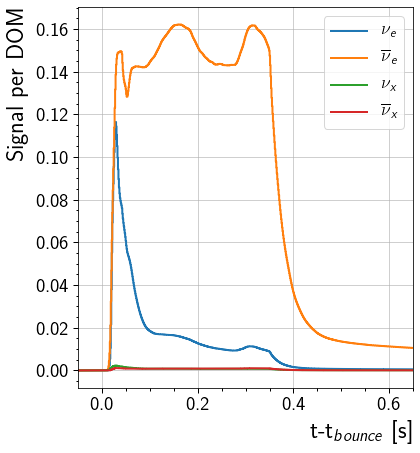

In [6]:
fig, ax = plt.subplots(1, figsize = (6,7))

for nu, flavor in enumerate(Flavor):
    ax.step( time, signal_per_DOM[nu], label=flavor.to_tex(), linewidth=2)
    
ax.set_ylabel( 'Signal per DOM', horizontalalignment='right', y = 1)
ax.set_xlabel(r't-t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set(xlim=(-0.05, 0.65))
ax.legend()